# Recherche bibliographique des modèles de propagation d'un virus

Les modèles de propagation d'une épidémie sont nombreux. Le plus simple est le modèle SIR comme nous avons pu l'implémenter dans l'application Dash de ce projet. Il permet de modéliser lévolution de l'appartenance de la population à 3 groupes : les Suceptibles, les Infectés et les Recovered (guéris). Les modèles plus complexes sont souvent basés sur ce modèle SIR en intégrant de nouvelles hypothèses. Par exemple, le modèle MSIR suppose que les bébés juste nés ne sont pas suceptibles de contracter le virus grâce à la protection des anti-corps de la mère, cette hypothèse est donc inclue au modèle SIR en rajoutant un groupe : les personnes immunes.

Une autre extension du modèle SIR est le modèle SEIR qui permet l'introduction d'une période d'incubation. SEIR modélise l'évolution d'appartenance à 4 groupes : 1 - Susceptibles, 2 - Exposed (infectés mais non infectieux), 3 - Infected, 4 - Recovered. Ce modèle repose sur 4 équations différentielles qui dépendent de 3 paramètres :
- alpha : l'inverse de la durée de la période d'incubation,
- beta : la probabilité d'infection,
- gamma : la probabilité de guérison.

Le modèle Threshold est un modèle qui peut être appliqué à la propagation d'un virus et n'est pas basé sur le modèle SIR. Dans ce modèle, lors d'une épidémie, un individu dispose de deux alternatives comportementales distinctes et mutuellement exclusives, par exemple la décision de participer ou de ne pas participer à un rassemblement. La décision individuelle d'un individu dépend du pourcentage de ses voisins qui ont fait le même choix, imposant ainsi un seuil. Le modèle fonctionne comme suit : - chaque individu a son propre seuil ; - à chaque itération, chaque individu est observé : si le pourcentage de ses voisins infectés est supérieur à son seuil, il devient également infecté.

Reférences : 
- Modèle MSIR : https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_MSIR_model
- Modèle SEIR :
https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296?gi=53b98c3c5110, http://homepages.warwick.ac.uk/~masfz/ModelingInfectiousDiseases/Chapter2/Program_2.6/index.html, 
https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SEIR.html
- Threshold model : 
https://sociology.stanford.edu/sites/g/files/sbiybj9501/f/publications/threshold_models_ajs_1978.pdf, https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html#id2

# Choix d'un modèle

Le modèle choisi dans le cadre de ce projet est le modèle SEIR. Ce modèle, prenant en considération une période d'incubation, est susceptible d'être adapté aux données disponibles sur le Covid-19 puisque ce virus présente également une période d'incubation de 1 à 14 jours (selon l'OMS https://www.who.int/fr/emergencies/diseases/novel-coronavirus-2019/advice-for-public/q-a-coronaviruses).

# Application numérique sur les données du corona virus

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import datetime

import yaml

In [2]:
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR, 
                         params['directories']['processed'], 
                         params['files']['all_data'])

# Lecture du fichiers des données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=["Last Update"])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df.day <= datetime.date(2020, 3, 27)]
              )

### Application du modèle sur la Corée du Sud

In [3]:
korea_df = (epidemie_df[epidemie_df['Country/Region'] == 'South Korea']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )

In [4]:
korea_df['infected'] = korea_df['Confirmed'].diff()

SEIR from scratch

In [6]:
alpha = 0.08
beta = 1.75
gamma = 0.5

size = korea_df.day.reset_index().index

In [36]:
def SEIR(t, init_vals):
        S_0, E_0, I_0, R_0 = init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        #alpha, beta, gamma = parameters
        dt = t[1] - t[0]
        for _ in t[1:]:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_R = R[-1] + (gamma*I[-1])*dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        return np.stack([S, E, I, R]).T

In [8]:
def loss(parameters, N):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = korea_df.day.reset_index().index
    alpha, beta, gamma = parameters
    
    def SEIR(t, init_vals):
        S_0, E_0, I_0, R_0 = init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        #alpha, beta, gamma = parameters
        dt = t[1] - t[0]
        for _ in t[1:]:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_R = R[-1] + (gamma*I[-1])*dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        return np.stack([S, E, I, R]).T
    
    solution = SEIR(size, [1 - 1/N, 1/N, 0, 0])[:,3]
    # solution = solve_ivp(SEIR, [size-1], [51_470_000, 1, 0, 0], t_eval=np.arange(0, size, 1), vectorized=True)
    
    return np.sqrt(np.mean((solution - korea_df['infected'])**2))

In [9]:
loss([alpha, beta, gamma], 51_470_000)

264.6317867048359

In [10]:
%%time
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

msol = minimize(loss, [0.08, 1.75, 0.5], 51_470_000, method='Nelder-Mead') # ne fonctionne pas
#msol.x

<ipython-input-8-6df870eaf11b>:14: RuntimeWarning: overflow encountered in double_scalars
  next_S = S[-1] - (beta*S[-1]*I[-1])*dt
<ipython-input-8-6df870eaf11b>:15: RuntimeWarning: overflow encountered in double_scalars
  next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
<ipython-input-8-6df870eaf11b>:15: RuntimeWarning: invalid value encountered in double_scalars
  next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
<ipython-input-8-6df870eaf11b>:14: RuntimeWarning: invalid value encountered in double_scalars
  next_S = S[-1] - (beta*S[-1]*I[-1])*dt


Wall time: 1.37 s


In [91]:
%matplotlib inline

In [37]:
results = SEIR(size, [51_470_000, 1, 0, 0])

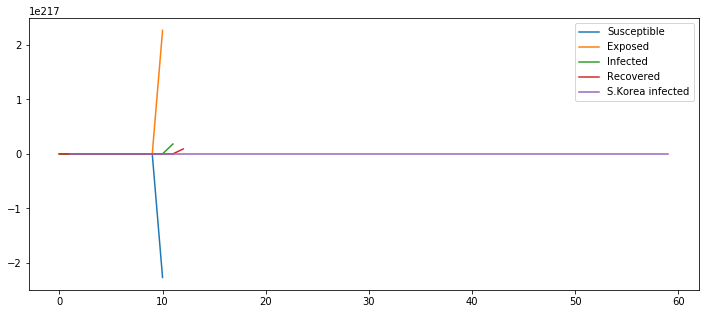

In [40]:
fig = plt.figure(figsize=(12, 5))
plt.plot(size, results[:,0], label='Susceptible');
plt.plot(size, results[:,1], label='Exposed');
plt.plot(size, results[:,2], label='Infected');
plt.plot(size, results[:,3], label='Recovered');
plt.plot(korea_df.day.index, korea_df.infected, label='S.Korea infected')
plt.plot
plt.legend()
plt.show()

SEIR with nlib library

In [13]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

In [29]:
alpha = 0.08
beta = 1.75
gamma = 0.5

nb_iterations = np.array(korea_df.day.reset_index().index)
fraction_infected = 0.01

In [30]:
def SEIR(parameters, nb_iterations, N, fraction_infected):
    
    alpha, beta, gamma = parameters 
    
    # Network topology
    g = nx.erdos_renyi_graph(N, 0.1)
    
    # Model selection
    model = ep.SEIRModel(g)
    
    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('alpha', alpha)
    cfg.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(cfg)
    
    # Simulation execution
    iterations = model.iteration_bunch(nb_iterations)
    
    # Count the number of people in each state at each iteration
    states_count = [sub['node_count'] for sub in iterations]
    
    # Number of suceptibles at each iteration
    susceptibles = np.array([dico[0] for dico in states_count])
    
    # Number of exposed at each iteration
    exposed =  np.array([dico[1] for dico in states_count])
    
    # Number of infected at each iteration
    infected =  np.array([dico[2] for dico in states_count])
    
    # Number of recovered at each iteration
    recovered = np.array([dico[3] for dico in states_count])
    
    return(pd.DataFrame({'infected': infected}))

In [31]:
def loss(parameters):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    def SEIR(parameters, nb_iterations, N, fraction_infected):
    
        alpha, beta, gamma = parameters 

        # Network topology
        g = nx.erdos_renyi_graph(N, 0.1)

        # Model selection
        model = ep.SEIRModel(g)

        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        cfg.add_model_parameter('alpha', alpha)
        cfg.add_model_parameter("fraction_infected", fraction_infected)
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(nb_iterations)

        # Count the number of people in each state at each iteration
        states_count = [sub['node_count'] for sub in iterations]

        # Number of suceptibles at each iteration
        susceptibles = np.array([dico[0] for dico in states_count])

        # Number of exposed at each iteration
        exposed =  np.array([dico[1] for dico in states_count])

        # Number of infected at each iteration
        infected =  np.array([dico[2] for dico in states_count])

        # Number of recovered at each iteration
        recovered = np.array([dico[3] for dico in states_count])

        return(pd.DataFrame({'infected': infected}))
    
    solution = SEIR(parameters, nb_iterations, N, fraction_infected)
    
    return np.sqrt(np.mean((solution - korea_df['infected'])**2))

In [32]:
%%time
from scipy.optimize import minimize

msol = minimize(loss, [alpha, beta, gamma], method='Nelder-Mead')
#msol.x

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
fig = plt.figure(figsize=(12, 5))

plt.plot(nb_iterations, SEIR([alpha, beta, gamma], nb_iterations, N, fraction_infected), label='Infected');
#plt.plot(korea_df.day.index, korea_df.infected/N*100, label='S.Korea infected')
plt.plot
plt.legend()
plt.show()